# Exact gradient
Let

$$
    J(u,m) = \frac{1}{2}\int_{\Omega\times\Omega}\!
    (u - u_d)^2\, dxdy 
    + \frac{\gamma}{2}\int_{\Omega\times\Omega}\!
    \nabla m \cdot \nabla m\, dxdy
$$

where 

$$
\begin{align*}
    -\nabla\cdot(e^m\nabla u) &= f 
    \text{ in }\Omega\times\Omega \\
    u &= 0 
    \text{ on }\partial(\Omega\times\Omega)
\end{align*}
$$

Then the directional derivative of $J$ with respect
to $m$ in the (arbitrary) direction of $\tilde m$ is

$$
    J_m(\tilde m) =
    \int_{\Omega\times\Omega}\!
    (\tilde m e^m)\nabla u \cdot \nabla p \, dxdy
    + \gamma\int_{\Omega\times\Omega}\!
    \nabla m \cdot \nabla \tilde m \, dxdy
$$

where the adjoint function $p$ solves

$$
\begin{align*}
    -\nabla\cdot(e^m\nabla p) &= -(u - u_d) 
    \text{ in }\Omega\times\Omega \\
    p &= 0 
    \text{ on }\partial(\Omega\times\Omega)
\end{align*}
$$

In [3]:
import numpy as np
from fenics import *

def analytic_grad(m, f, n=11, gamma=1):
    """computes int _m e^m nabla(u) dot nabla(p) dxdy
    + gamma int nabla(m) dot nabla(_m) dxdy
    where _m is a placeholder for each basis element"""
    
    # given m, solve F(u, m) = 0 for u
    mesh = UnitSquareMesh(n-1, n-1)
    V = FunctionSpace(mesh, 'CG', 1)
    v2d = vertex_to_dof_map(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    
    m = interpolate(Expression(m, element=V.ufl_element()), V)
    f = interpolate(Expression(f, element=V.ufl_element()), V)
    u, v = Function(V), TestFunction(V)
    
    F = exp(m) * inner(grad(u), grad(v)) * dx - f * v * dx
    solve(F==0, u, bc)
    
    # given m and u, solve adjoint eq for p
    p, v = Function(V), TestFunction(V)
    u_d = Function(V) # let data=0
    F_adj = exp(m) * inner(grad(p), grad(v)) * dx + (u - u_d)**2 * v * dx
    solve(F_adj==0, p, bc)
    
    # given m, u and p, compute analytic gradient
    grads = np.zeros(V.dim())
    for i in range(V.dim()):
        _m = Function(V)
        _m.vector()[i] = 1.
        grad_i = _m * exp(m) * inner(grad(u), grad(p)) * dx + gamma * inner(grad(m), grad(_m)) * dx
        grads[i] = assemble(grad_i)
    return grads[v2d]

In [4]:
from fenics_adjoint import *

def fenics_adj_grad(m, f, n=11, gamma=1):
    """automates analytic_grad using fenics_adjoint"""
    tape = get_working_tape()
    tape.clear_tape()
    mesh = UnitSquareMesh(n-1, n-1)
    V = FunctionSpace(mesh, 'CG', 1)
    v2d = vertex_to_dof_map(V)
    bc = DirichletBC(V, 0, 'on_boundary')
    
    m = interpolate(Expression(m, element=V.ufl_element()), V)
    f = interpolate(Expression(f, element=V.ufl_element()), V)
    u, v = Function(V), TestFunction(V)
    
    F = exp(m) * inner(grad(u), grad(v)) * dx - f * v * dx
    solve(F==0, u, bc)
    
    u_d = Function(V) # let data=0
    J = assemble(0.5 * (u - u_d)**2 * dx + gamma / 2 * inner(grad(m), grad(m)) * dx)
    
    # do taylor test
#     h = Function(V)
#     h.vector()[:] = 0.01
#     Jhat = ReducedFunctional(J, Control(m))
#     conv_rate = taylor_test(Jhat, m, h)
#     return conv_rate
    control = Control(m)
    grads = compute_gradient(J, control)
    return grads.vector()[v2d]

Using the usual Lagrangian approach, we can write down
the analytic weak formulations of the 
state, adjoint, and sensitivity equations:

$$
\begin{align}
    \mathcal{L}_p(u, m, p)(\tilde p) &= 
    \int\! e^m\nabla u\cdot\nabla \tilde p\, dxdy 
    - \int\! f\tilde p\, dxdy\\
    \mathcal{L}_u(u, m, p)(\tilde u) &= 
    \int\! (u-u_d)\tilde u\, dxdy
    + \int\! e^m\nabla p\cdot\nabla\tilde u\, dxdy\\
    \mathcal{L}_m(u, m, p)(\tilde m) &= 
    \int\! (\tilde m e^m)\nabla u\cdot\nabla p\, dxdy
    + \gamma \int\! \nabla m\cdot\nabla\tilde m\, dxdy
\end{align}
$$

The goal of this section is to rewrite these as 
Kronecker products of matrices whose entries are
integrals over $\Omega$. Note the arbitrary directions
(denoted with tildes) need only be computed for each
basis element. The big picture flow is:

1. Given $m$, solve the state equation (1) for $u$
1. Given $m$ and $u$, solve the adjoint equation (2) for $p$
1. Given $m$, $u$, and $p$, compute the functional sensitivity (3) and update $m$
1. Return to step 1.

## State equation discretization
We obtain the state equation by setting (1) equal to zero. In other words, $\mathcal{L}_p(u, m, p)(\tilde p) =0$ after discretization is the same as $Au - b = 0$. 
For this particular problem the product stiffness
matrix $A$ is not of the form $B\otimes C + C\otimes B$.
Instead it looks more like $B\otimes C + D\otimes E$.
For instance, assuming $m(x,y) = m_1(x) + m_2(y)$
(so that $e^m = e^{m_1}e^{m_2}$) we have

$$
A_{ij,k\ell} = 
\left(\int_\Omega\! e^{m_1}\phi'_j\hat\phi'_i\, dx\right) 
\left(\int_\Omega\! e^{m_2}\phi_\ell\hat\phi_k\, dy\right)
+ \left(\int_\Omega\! e^{m_1}\phi_j\hat\phi_i\, dx\right) 
\left(\int_\Omega e^{m_2} \phi'_\ell\hat\phi'_k\, dy\right)
$$

This is not the case when $m$ is univariate, however.
Further assuming $f$ is separable such that 
$f(x,y) = f_1(x)f_2(y)$, the right hand side 
of the linearized state equation is

$$
b_{ij} = \left(\int_\Omega\! f_1 \hat\phi_i\, dx\right) 
\left(\int_\Omega\! f_2\hat\phi_j\, dy\right)
$$

## Adjoint equation discretization
We obtain the adjoint equation by setting (2) equal to zero.
In other words, $\mathcal{L}_u(u, m, p)(\tilde u) = 0$
after discretization is the same as $A^T p - c = 0$
To solve the adjoint equation $A^T p = c$ we need only
compute the right hand side $c$ and apply vanishing boundary conditions on $p$. 
Let $\epsilon(x,y) = u_d(x,y) - u(x,y)$ so that 
$\epsilon(x,y) = \sum_{ij}\epsilon_{ij}\phi_i(x)\phi_j(y)$.
It follows that the adjoint right hand side is

$$
c_{ij} = \sum_{k\ell}\epsilon_{k\ell}
\int\! \phi_k(x)\phi_\ell(y)\phi_i(x)\phi_j(y)\, dxdy = \epsilon^T K\otimes K
$$

where $K_{ij} = \int_\Omega\! \phi_i\phi_j \, dx$
and $\epsilon$ is the vector of nodal values of $u_d - u$.

## Sensitivity equation discretization
We obtain the sensitivity equation by setting (3) equal to zero, since we will have a local optimum when the gradient vanishes. In practice, we are only interested
in computing 
$\mathcal{L}_m(u, m, p)(\tilde m)$
to inform how we can update $m$.
After solving the state and adjoint equations we have
$u$ and $p$, so we need only compute

$$
    \frac{dJ}{dm} = p \left(\frac{\partial b}{\partial m} 
    - \frac{\partial A}{\partial m}u\right)
    + \frac{\partial J}{\partial m}
$$

Now, since $\frac{\partial b_{ij}}{\partial m_{k\ell}} = 0$ for all $i,j,k,\ell$ we have
$\frac{\partial b}{\partial m} = 0$.
Next we seek to compute 
$\frac{\partial A_{ij,k\ell}}{\partial m_{rs}}$ and
$\frac{\partial J}{\partial m_{rs}}$,
which amounts to computing the first and second terms,
respectively, in (3) using an arbitrary basis function
$\tilde m(x,y) = \phi_r(x)\phi_s(y)$.
Recall

$$
A_{ij,k\ell} = 
\left(\int_\Omega\! e^{m_1}\phi'_j\hat\phi'_i\, dx\right) 
\left(\int_\Omega\! e^{m_2}\phi_\ell\hat\phi_k\, dy\right)
+ \left(\int_\Omega\! e^{m_1}\phi_j\hat\phi_i\, dx\right) 
\left(\int_\Omega e^{m_2} \phi'_\ell\hat\phi'_k\, dy\right)
$$

and hence 

$$
\frac{\partial A_{ij,k\ell}}{\partial m_{rs}} = 
\left(\int_\Omega\! \phi_re^{m_1}\phi'_j\hat\phi'_i\, dx\right) 
\left(\int_\Omega\! \phi_se^{m_2}\phi_\ell\hat\phi_k\, dy\right)
+ \left(\int_\Omega\! \phi_re^{m_1}\phi_j\hat\phi_i\, dx\right) 
\left(\int_\Omega \phi_se^{m_2} \phi'_\ell\hat\phi'_k\, dy\right)
$$

Similarly,

$$
\frac{\partial J}{\partial m_{rs}} = 
\gamma\int\!\nabla m \cdot \nabla (\phi_r\phi_s) \, dxdy
= \gamma\int_\Omega\! m'_1\phi'_r\, dx
\int_\Omega\!\phi_s\, dy
+ \gamma\int_\Omega\!\phi_r\, dx
\int_\Omega\!m'_2\phi'_s\, dy
$$

In [5]:
import product_fem as pf
import seaborn as sns

def product_space_grad(m, f, n=11, gamma=1):
    """assume m = X(x) + Y(y) and f = X(x)Y(y)
    assemble product space system, solve for u
    assemble adjoint product space system, solve for p
    assemble dbdm, dAdm, dJdm
    gradient is p * (dbdm - dAdm * u) + dJdm"""
    mesh = UnitIntervalMesh(n-1)
    V = FunctionSpace(mesh, 'CG', 1)
    W = pf.ProductFunctionSpace(V)
    bc = pf.ProductDirichletBC(W, 0, 'on_boundary')
    
    # assemble forward system and solve for u
    # weak form: a(u,v) = e^m grad(u) dot grad(v) dx
    #            L(v) = f * v * dx
    m_x = interpolate(Expression(m[0], element=V.ufl_element()), V)
    m_y = interpolate(Expression(m[1], element=V.ufl_element()), V)
    f_x = interpolate(Expression(f[0], element=V.ufl_element()), V)
    f_y = interpolate(Expression(f[1], element=V.ufl_element()), V)
    m_dim = len(m_x.vector()[:]) ** 2
    
    u, v = TrialFunction(V), TestFunction(V)
    A_forms = [exp(m_x) * u.dx(0) * v.dx(0) * dx,
               exp(m_y) * u * v * dx,
               exp(m_x) * u * v * dx,
               exp(m_y) * u.dx(0) * v.dx(0) * dx]
    b_forms = [f_x * v * dx,
               f_y * v * dx]
    A, b = pf.assemble_product_system(A_forms, b_forms, bc)
    u = np.linalg.solve(A, b)
    
    # plot stiffness sparsity
    sns.heatmap(A)
    
    # assemble adjoint system and solve for p
    # no need to reassemble adjoint stiffness just take transpose
    # rhs is residuals^T K \otimes K where K_ij = \phi_i \hat\phi_j dxdy
    p, v = TrialFunction(V), TestFunction(V)
    K = assemble(p * v * dx).array()
    u_d = np.zeros_like(u) # assume u_d = 0 for now
    eps = -(u - u_d)
    b_adj = eps.T.dot(np.kron(K, K))
    
    A_adj, b_adj = bc.apply(A.T, b_adj)
    p = np.linalg.solve(A_adj, b_adj).T
    
    # assemble dbdm, dAdm, dJdm
    # here b is independent of m so dbdm = 0
    dbdm = np.zeros((len(b), m_dim))
    
    # loop over rs
    dofs = W.dofmap.marginal_dofs
    dAdm = np.zeros((A.shape + (m_dim,)))
    dJdm = np.zeros((1, m_dim))
    uu = TrialFunction(V)
    for r in dofs:
        phi_r = Function(V)
        phi_r.vector()[r] = 1.
        for s in dofs:
            rs = s + r * len(dofs)
            phi_s = Function(V)
            phi_s.vector()[s] = 1.
            
            # dAdm = (phi_r phi_s e^m) inner(grad(u), grad(p)) dxdy
            dAdm_forms = [phi_r * exp(m_x) * uu.dx(0) * v.dx(0) * dx,
                          phi_s * exp(m_y) * uu * v * dx,
                          phi_r * exp(m_x) * uu * v * dx,
                          phi_s * exp(m_y) * uu.dx(0) * v.dx(0) * dx]
            dAdm[:,:,rs] = pf.assemble_kron(dAdm_forms)

            # dJdm = gamma inner(grad(m), grad(phi_r phi_s)) dxdy
            dJdm_forms = [phi_r.dx(0) * m_x.dx(0) * dx,
                          phi_s * dx,
                          phi_r * dx,
                          phi_s.dx(0) * m_y.dx(0) * dx]
            dJdm[0,rs] = gamma * pf.assemble_kron(dJdm_forms)
    
    # compute gradient = p * (dbdm - dAdm * u) + dJdm
    dFdm = dbdm - np.tensordot(dAdm, u, axes=(1,0))
    return p.dot(dFdm) + dJdm

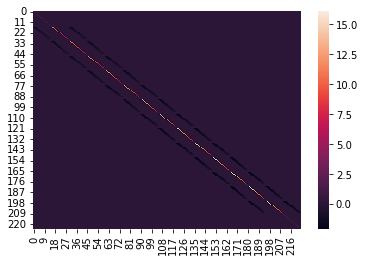

In [12]:
n = 15
m = 'cos(x[0]) + sin(x[1])' # additively separable
f = 'exp(-x[0]) * cos(x[1])' # multiplicative separable
gamma = 0.1
grads1 = analytic_grad(m, f, n, gamma)
grads2 = fenics_adj_grad(m, f, n, gamma)

m = ['cos(x[0])', 'sin(x[0])']
f = ['exp(-x[0])', 'cos(x[0])']
grads3 = product_space_grad(m, f, n, gamma)

In [13]:
# product to fenics permutation:
# grads[v2d] in fenics will be ordered as 
# grid rows (left to right) bottom to top
# product_grads will be ordered as 
# grid columns (top to bottom) right to left
# want permutation p2f such that grads[v2d]==product_grads[p2f]
# so in an n by n uniform grid,
p2f = [-i-j*n for i in range(1,n+1) for j in range(n)]
grads3 = grads3.flatten()[p2f]
# NOTE this is a special case and we probably need a mesh independent construction

In [14]:
print(np.corrcoef(grads1, grads2), np.linalg.norm(grads1 - grads2))
print(np.corrcoef(grads2, grads3), np.linalg.norm(grads2 - grads3))
print(np.corrcoef(grads1, grads3), np.linalg.norm(grads1 - grads3))

[[1. 1.]
 [1. 1.]] 2.849730854226369e-06
[[1. 1.]
 [1. 1.]] 5.7982296096724205e-06
[[1. 1.]
 [1. 1.]] 2.949554546607491e-06


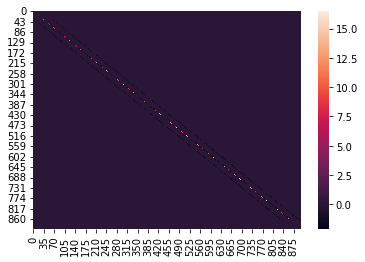

In [9]:
n = 30
m = 'cos(x[0]) + sin(x[1])' # additively separable
f = 'exp(-x[0]) * cos(x[1])' # multiplicative separable
gamma = 0.1
grads1 = analytic_grad(m, f, n, gamma)
grads2 = fenics_adj_grad(m, f, n, gamma)

m = ['cos(x[0])', 'sin(x[0])']
f = ['exp(-x[0])', 'cos(x[0])']
grads3 = product_space_grad(m, f, n, gamma)

# Optimization

Ok now let's see how `scipy.optimize.minimize` performs.

Define the product mass matrix $M$ by

$$
M_{ij} = \int_{\Omega_1} \phi_i\, dx \int_{\Omega_2} \phi_j\, dy
$$

Given some function $f$ on $\Omega\times\Omega$
we can approximate its integral 

$$
\int\! f(x,y) \,dxdy = 
\sum_{ij} f_{ij}\int\! \phi_i(x)\, dx\int\!\phi_j(y) \, dy =
\langle f, M\rangle
$$

In other words we can precompute $M$ _once_ 
and dot it with the dof values of $f$.

In [7]:
import scipy.optimize as opt

def compute_product_mass(V):
    Phi = np.zeros((n,n))
    for i in range(n):
        phi_i = Function(V)
        phi_i.vector()[i] = 1.
        for j in range(n):
            phi_j = Function(V)
            phi_j.vector()[j] = 1.
            Phi[i,j] = assemble(phi_i * dx) * assemble(phi_j * dx)
    return Phi

def loss_and_grad(m, u_data, f, gamma):
    """ (m, u_data) -> (J, dJdm) """
    # FORWARD (m -> u)
    mesh = UnitIntervalMesh(n-1)
    V = FunctionSpace(mesh, 'CG', 1)
    W = pf.ProductFunctionSpace(V)
    bc = pf.ProductDirichletBC(W, 0, 'on_boundary')
    
    # assemble forward system and solve for u
    # weak form: a(u,v) = e^m grad(u) dot grad(v) dx
    #            L(v) = f * v * dx
    m_x = interpolate(Expression(m[0], element=V.ufl_element()), V)
    m_y = interpolate(Expression(m[1], element=V.ufl_element()), V)
    f_x = interpolate(Expression(f[0], element=V.ufl_element()), V)
    f_y = interpolate(Expression(f[1], element=V.ufl_element()), V)
    m_dim = len(m_x.vector()[:]) ** 2
    
    u, v = TrialFunction(V), TestFunction(V)
    A_forms = [exp(m_x) * u.dx(0) * v.dx(0) * dx,
               exp(m_y) * u * v * dx,
               exp(m_x) * u * v * dx,
               exp(m_y) * u.dx(0) * v.dx(0) * dx]
    b_forms = [f_x * v * dx,
               f_y * v * dx]
    A, b = pf.assemble_product_system(A_forms, b_forms, bc)
    u = np.linalg.solve(A, b)
    
    # LOSS (m, u -> J)
    resids = 0.5 * (u - u_data)**2
    J = np.dot(resids, Phi) + 0.5 * gamma * inner(grad(m), grad(m)) * dx
    
    # BACKWARD (m, u -> dJdm)
    # assemble adjoint system and solve for p
    # no need to reassemble adjoint stiffness just take transpose
    # rhs is residuals^T K \otimes K where K_ij = \phi_i \hat\phi_j dxdy
    p, v = TrialFunction(V), TestFunction(V)
    K = assemble(p * v * dx).array()
    u_d = np.zeros_like(u) # assume u_d = 0 for now
    eps = -(u - u_d)
    b_adj = eps.T.dot(np.kron(K, K))
    
    A_adj, b_adj = bc.apply(A.T, b_adj)
    p = np.linalg.solve(A_adj, b_adj).T
    
    # assemble dbdm, dAdm, dJdm
    # here b is independent of m so dbdm = 0
    dbdm = np.zeros((len(b), m_dim))
    
    # loop over rs
    dofs = W.dofmap.marginal_dofs
    dAdm = np.zeros((A.shape + (m_dim,)))
    dJdm = np.zeros((1, m_dim))
    uu = TrialFunction(V)
    for r in dofs:
        phi_r = Function(V)
        phi_r.vector()[r] = 1.
        for s in dofs:
            rs = s + r * len(dofs)
            phi_s = Function(V)
            phi_s.vector()[s] = 1.
            
            # dAdm = (phi_r phi_s e^m) inner(grad(u), grad(p)) dxdy
            dAdm_forms = [phi_r * exp(m_x) * uu.dx(0) * v.dx(0) * dx,
                          phi_s * exp(m_y) * uu * v * dx,
                          phi_r * exp(m_x) * uu * v * dx,
                          phi_s * exp(m_y) * uu.dx(0) * v.dx(0) * dx]
            dAdm[:,:,rs] = pf.assemble_kron(dAdm_forms)

            # dJdm = gamma inner(grad(m), grad(phi_r phi_s)) dxdy
            dJdm_forms = [phi_r.dx(0) * m_x.dx(0) * dx,
                          phi_s * dx,
                          phi_r * dx,
                          phi_s.dx(0) * m_y.dx(0) * dx]
            dJdm[0,rs] = gamma * pf.assemble_kron(dJdm_forms)
    
    # compute gradient = p * (dbdm - dAdm * u) + dJdm
    dFdm = dbdm - np.tensordot(dAdm, u, axes=(1,0))
    return J, p.dot(dFdm) + dJdm

In [2]:
mesh = UnitIntervalMesh(n-1)
V = FunctionSpace(mesh, 'CG', 1)
M = compute_product_mass(V)

In [ ]:
# prep for optimizing:
# fix force function f and regularization parameter gamma 
f = ...
gamma = 0.3

# fix ground truth for m, simulate u_data from it
m_truth = ...
u_data = forward(m_truth, f, gamma)

# make initial guess m0 for m
m0 = np.zeros_like(m_truth)

In [ ]:
# opt.minimize will minimize 
# objective function fun (callable) such that
#    fun(m, *args) -> float
# with initial guess m0 (ndarray, shape (n,))
# and additional args (tuple) to fun
# using optimization method (e.g. ‘L-BFGS-B’) 
# and gradient vector jac (callable) such that
#    jac(m, *args) -> array_like, shape (n,)

# alternatively, if jac is True it is assumed
#    fun(m, *args) -> loss, grad

# might need bounds on args 

fun = loss_and_grad
args = (u_data,)
method = 'L-BFGS-B'
jac = True

opt.minimize(fun, m0, args, method, jac)